# D7046E Exercise 0 - Getting started with Python, Jupyter, and PyTorch

**After completing this exercise you should complete the Assignment quiz in Canvas to self-assess your understanding. Your code/solution of this exercise should not be submitted and will not be assessed by a teacher. This exercise is required as preparation before the next exercise, so please make sure that you understand the following before continuing.**

In this exercise you will perform some machine learning programming tasks aiming to a) introduce the programming environment and b) learn how to implement basic machine learning models including a neural network. In the subsequent exercises in the course you will learn more about how neural networks function and how different types of neural networks can be implemented and used.

This exercise is split in two parts. First, you will train some basic machine learning models that aren't neural networks using [scikit-learn](https://scikit-learn.org/). Secondly, you will implement and train an artificial neural network (ANN) using [pytorch](https://pytorch.org/).

In order to train a model with machine learning, we require one thing above all else: *data*! We need data that contains information about the desired input-ouput relationship so that we can optimize a machine-learning model, $y=f(x,theta)$, where the variables are vectors/tensors and $theta$ are *trainable parameters* that are optimized so that the model fits the data. This typically involves minimizing the error of the model, often refered to *loss*, to whatever task and data we have at hand.

The data that you will use in this task is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which contains handwritten numbers from 0-9. Some samples from the dataset can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Your task is to train machine learning models that can classify samples from the MNIST dataset. This illustrates how machine learning can be used to solve problems that are diffcult (if not impossible) to program "bottom-up" from first principles. It will also introduce concepts needed to tackle more complex machine learning tasks with PyTorch and Scikit-Learn.

Before you start this exercise it is recommended that you read the "Getting ready for the Exercises" PDF that can be found in Canvas. The first cell below will check if everything seems to be installed correctly, if not, first check the instructions in the PDF. If the problem persists, please describe the issue in the discussion group for exercises in Canvas.

Press the CONTROL + ENTER keys to run a selected block of code or text. Double click text blocks to edit them and press CONTROL + ENTER to turn it back into text. Whenever you've updated some code in a cell you need to run it again to execute those changes. If the changes in that cell is used in another cell you need to run that cell again as well.

In [2]:
# Importing packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot as to_onehot
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import copy

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

print('The installation seems to be working!')

The installation seems to be working!


## Literature
Before starting programming you may want to read Chapter 5 in the [deep learning book](https://www.deeplearningbook.org/). This will help you understand the basics of machine learning. See in particular the following parts:

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is (including linear regression).
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.

If you are already familiar with the basics of machine learning you can skip that chapter and continue with the exercise.

## MNIST dataset preparation
Start by downloading and preparing the data so that it is usable for our purposes. MNIST consist of 70,000 grayscale images of size 28x28 pixels each. Our goal is to train models that can recognize what digit an image represents. The code below gets the dataset (downloads it if necessary) and displays one of the images.

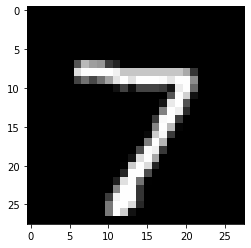

In [3]:
# Get the training split of the MNIST dataset, the ToTensor makes sure we get the data as tensors, not images
mnist_train = torchvision.datasets.MNIST('./', train=True, download=True, transform=torchvision.transforms.ToTensor())

mnist_test = torchvision.datasets.MNIST('./', train=False, download=True, transform=torchvision.transforms.ToTensor())
# Create a DataLoader from the dataset that we'll use to get batches of data during training
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=False)

# Function that takes an MNIST tensor and shows the image
def plot_digit(data):
    # Transfrom the images into an appropriate shape for displaying
    data = data.view(28,28)
    plt.imshow(data, cmap='gray')
    plt.show()

# Get the first batch of images and labels from the DataLoader
images, labels = next(iter(test_loader))

# Plot the first image of the batch
plot_digit(images[0])


## Task 1

Neural Networks are just one part of the large field of machine learning. Many machine learning models exist that does not fall under the umbrella of neural networks. It's good to be familiar with some of them and learn where to acquire further information when needed. In this part of the exercise you will test decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM) models using their implementations in the scikit-learn package.

Here follows a brief walk-through of the methods:

**Decision trees** work by inserting a data point into the root of the tree and then by comparing different features of the data point it is sent to the next step in the tree until it reaches a leaf node which contains the final prediction for the data point. There are many different ways to create a tree to fit some training set but training procedures often follow a divide-and-conquer strategy:
* Find an attribute that splits the different classes or labels of the training data as neatly as possible and create a node that splits using that attribute.
* Repeat the procedure to create the subnodes using the training data that subnode would encounter.
* This is repeated for each until either a performance requirement or a certain depth is reached at which point each leaf node is assigned as a predictor for the highest liklihood label to reach that node.

An example of a short decision tree can be found in the image below.

![Decision Tree](https://miro.medium.com/max/720/1*YTg8AE3nAsbfn-elHuJNIA.jpeg)

**Linear regression, logistic regression, and support vector machines (SVMs)** are all versions of linear models. Linear models work by learning a hyperplane (a plane with N-1 dimensions) for training data in some hyper-space (a space with N dimensions) that fits the data the best. In the case of binary classification the goal is to have as many samples of each class on separate sides of the plane.



The calculation of a linear model can be described by the vector equation below, where *x* is the data point and **w** and b are learned parameters, and f() is an activation function.

\begin{equation*}
y = f(\mathbf{w}\mathit{x} + b)
\end{equation*}

As you can see this is identical to the equation of an artificial neuron, and when extended to handle multiple outputs (by using  matrices for **w** and b instead of vectors) become equivalent to a single-layer ANN.
However, even though prediction, in the simplest case, is equivalent to a single-layer neural network there are many different linear models that vary in different ways. Common things to change is activation function, learning method, optimization criteria, or the addition of kernel functions to bring complex datasets into higher dimensional spaces where it's easier to linearly separate. So, while it may seem pointless to use a linear model when they seem equivalent to a single-layer neural network, some models come with advantages that neural network have difficulty replicating. A common advantage is that while neural networks often needs to be trained using backpropagation, linear models are well-studied with many different optimization short-cuts and techniques.

As you will see when running the models below, these models all get impressive results on the dataset, despite their apparent simplicity. To test these models we're using their implementation from the Python library [Scikit-Learn](https://scikit-learn.org/stable/index.html) which contains implementations of a host of different machine learning models and methods. While knowing a Scikit-Learn is not mandatory for this Exercise, it's well worth having a look at for anyone interested in non-neural network machine learning (though it does contain some neural networks as well).

### Task 1.1
Analyse the code below and run it to get the results of the different machine learning models (You might get some warnings, but don't worry about those).

In [5]:
# Since Scikit-Learn uses Numpy we need to transform all our data to numpy arrays,
# which can be done by Pytorch's .numpy() function
X_train = mnist_train.data.view(-1, 784).numpy()
y_train = mnist_train.targets.numpy()
y_10_train = to_onehot(mnist_train.targets).detach().numpy()

X_test = mnist_test.data.view(-1, 784).numpy()
y_test = mnist_test.targets.numpy()

# Many machine learning models in Sciki-Learn work better if the data has been normalized to mean 0 and standard deviation 1, which can be done with Scikit-Learn's StandardScaler
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We make a function for handling the training and testing of a given Scikit-Learn classifier
def train_and_test(classifier, train_data, train_labels, test_data, test_labels, onehot_output=False):
    # Trains the classifier witht he given data and labels
    classifier.fit(train_data, train_labels)
    # Uses the trained classifier to predict the classes of the test set
    predictions = classifier.predict(test_data)
    # Some models output with predictions for each class rather than one index for the predicted class
    if onehot_output:
        predictions = numpy.argmax(predictions, axis=1)
    # By comparing the actual labels to the predictions we can calculate the accuracy of the classifier
    return accuracy_score(test_labels, predictions)


# We create the classifiers to test. 'log'-loss is called 'los_loss' in some package versions, so we've included both for your convenience.
try:
    classifiers = {
        "Decision Tree": DecisionTreeClassifier(),
        "Linear Regression": LinearRegression(),
        # We use the SGDClassifier (which trains a linear model using SGD) to implement Logistic Regression and SVM
        "Logistic Regression": SGDClassifier(loss='log', max_iter=100),
        "SVM": SGDClassifier(loss='hinge', max_iter=100)
    }

except:
    classifiers = {
        "Decision Tree": DecisionTreeClassifier(),
        "Linear Regression": LinearRegression(),
        # We use the SGDClassifier (which trains a linear model using SGD) to implement Logistic Regression and SVM
        "Logistic Regression": SGDClassifier(loss='log_loss', max_iter=100),
        "SVM": SGDClassifier(loss='hinge', max_iter=100)
    }

# We train and test each classifier
for classifier in classifiers:
    onehot_output = classifier == "Linear Regression"
    y = y_10_train if onehot_output else y_train
    result = train_and_test(classifiers[classifier], X_train, y, X_test, y_test, onehot_output=onehot_output)
    print("Classifier {} got {}% accuracy on the test set".format(classifier, result*100))

Classifier Decision Tree got 87.77000000000001% accuracy on the test set
Classifier Linear Regression got 86.02% accuracy on the test set


c:\Users\karle\anaconda3\envs\NNLM_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Classifier Logistic Regression got 87.5% accuracy on the test set
Classifier SVM got 89.18% accuracy on the test set


c:\Users\karle\anaconda3\envs\NNLM_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### Task 1.2
Read up on linear and logistic regression and write a short description of their difference in the cell below. Explain in three or four sentences the main differences.

<i>Write your answer here 
...
...
... </i>



## Task 2

Next you will implement an ANN (read the information given at the top of this document if you have forgotten what that acronym means - it is one of the central themes in this course!) that classifies the MNIST digits.

In this course you will be using the deep learning framework **PyTorch** to implement ANNs. This exercise is an introduction to the framework. We recommend this [tutorial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) as reference for further information.

To solve the following task you will need to improve the code provided below. This can be done by adding or changing the modules that are part of nn.Sequential. A list of available modules can be found [here](https://pytorch.org/docs/stable/nn.html) though it's recommended that you stick with nn.Linear, nn.Sigmoid, nn.ReLU, nn.LeakyReLU, or similar modules. Feed-Forward networks (the type recommended for this task, we'll tell you more about that later) usually consist of nn.Linear separated by activation functions (like nn.Sigmoid, and nn.Linear). Each nn.Linear layer must have the input size (first parameter) of the previous layer's output size. E.g. nn.Linear(784, 50) could be followed by nn.Linear(50, 10).

For inspiration, see the MNIST [website](http://yann.lecun.com/exdb/mnist/) which contains some previously tested network architectures and the corresponding classification accuracy obtained.

Additionally, you might want to change the optimizer used; (List [here](https://pytorch.org/docs/stable/optim.html)) or loss function (List [here](https://pytorch.org/docs/stable/nn.html#loss-functions)).

Note: Not all loss functions takes the same input, so you might need to restructure the data to make it work.

Any network that you design will be randomly initialized and therefore bad at recognizing images initially, which you will experience when running the code below.

### Task 2.1

Predicting with the randomly initialized network before training to see what happens


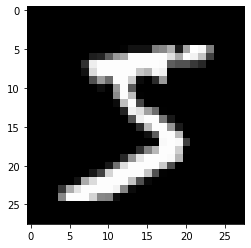

Prediction: 8 - Actual: 5


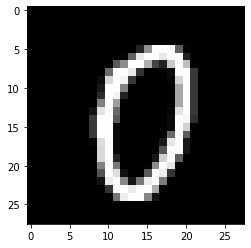

Prediction: 2 - Actual: 0


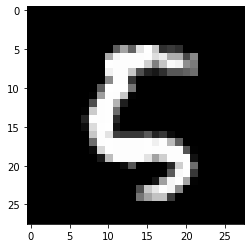

Prediction: 4 - Actual: 5


In [4]:
# This code initializes the neural network

### EDIT CODE BELOW TO CHANGE THE NETWORK AND ITS OPTIMIZING PROCEDURE ###
# nn.Sequential can be given a list of neural networks modules

# This initial network has only two layers with a ReLU funtion in between.
# It has an input size equal to the size of the images (28x28 pixels = 784)
# and an output size equal to the number of classes (the number of digits = 10)
network = nn.Sequential(
    nn.Linear(784, 100), # First layer of the network takes the entire image and reduces it to 100 dimensions
    nn.ReLU(),
    nn.Linear(100, 10) # The second layer takes those 100 dimensions and reduces them into estimeated values for each digit
)

# Initialize the optimizer
# In addition to changing optimizer you can try to change other parameters like learning rate (lr)
optimizer = optim.SGD(network.parameters(), lr=0.01)

# Initialize the loss function
loss_function = nn.MSELoss()

### EDIT CODE ABOVE TO CHANGE THE NETWORK AND ITS OPTIMIZING PROCEDURE ###

# An Embedding layer used for turning int into one-hot (0 -> [1,0,0,0,0,0,0,0,0,0], 5 -> [0,0,0,0,0,1,0,0,0,0])
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

# Extract some images from the dataset and have the new predict what digit they are
def predict_on_images(iterator, images_to_show):
    for index in range(images_to_show):
        # Get the next batch of images
        images, labels = next(iterator)

        plot_digit(images[0])

        # Transform the images into a single list of pixels since our network takes that as its input
        input_tensor = images[0].view(1,784)
        # Run the input through our network to get a prediction
        prediction = network(input_tensor)
        # Extract which prediction had the highest probability
        guess = torch.argmax(prediction[0], dim=-1)
        # Show the predicted digit and the actual digit
        print(f'Prediction: {guess.item()} - Actual: {labels[0].item()}')

# Have the untrained network predict on some images
print('Predicting with the randomly initialized network before training to see what happens')
mnist_loader = train_loader
predict_on_images(iterator = iter(mnist_loader), images_to_show = 3)

### Task 2.2: training the network
Below is the training procedure. Neural networks are usually trained with backpropagation which works as follows (for now you don't need to understand the prodcedure, but you'll be expected to learn it in the course later on).<br>
    1. Give the network the input and have it calculate a prediction.<br>
    2. Calculate the loss/error by comparing the difference between the prediction and the target output.<br>
    3. For the error E and each parameter w find their error gradient: (backpropagate the error)
\begin{equation*}
\frac{\partial E}{\partial w}
\end{equation*}
    4. Update the parameters according to their error gradient (since we know how this parameter affected the error we can change it to cause less error)<br>
    5. Repeat from step 1 with new input
    
The code below **takes a while to execute**. Note the cirle at the top-right corner of the notebook, just next to the name Python followed by the version number, like **Python 3**. When the circle is filled the code is still running. An open circle means that code is not running.

**Exercise:** Complete the training loop below and train the network. Then go back to where the network and other training parameters are defined and change things around and see if you can train with some other network architectures, loss functions, or optimizers.

*Hint:* Look at the training loop from the seven segment training to see how different parts are implemented

In [ ]:
# Decide the number of epochs to train for (one epoch is one optimization iteration on the entire dataset)
epochs = 10

# For each epoch
for epoch in range(epochs):

    # For each batch of data (since the dataset is too large to run all data through the network at once)
    for batch_nr, (images, labels) in enumerate(mnist_loader):

        # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
        labels = to_onehot(labels)

        # Reshape the images to a single vector (28*28 = 784)
        images = images.view(-1,784)

        # Predict for each digit in the batch whatclass they belong to
        prediction = ... # WRITE THE CODE TO RUN THE IMAGES THROUGH THE NETWORK

        # Calculate the loss of the prediction by comparing to the expected output
        loss = ... # WRITE THE CODE TO CALCULATE THE LOSS BY COMPARING THE PREDICTION TO THE ACTUAL LABELS

        # Backpropagate the loss through the network to find the gradients of all parameters
        ... # WRITE CODE TO BACKPROPOGATE THE LOSS

        # Update the parameters along their gradients
        ... # WRITE THE CODE TO OPTIMIZE PARAMETERS BY STEPPING ALONG THE GRADIENTS

        # Clear stored gradient values
        ... # WRITE THE CODE TO REMOVE THE USED GRADIENTS BEFORE THE NEXT ITERATION OF THE LOOP

        #Print the epoch, batch, and loss
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(mnist_loader), loss
            ),
            end=''
        )

Epoch 10 [60/60] - Loss: 0.06694659590721139

### Task 2.3: Testing the network
To see whether our network have been trained properly we want to test it on new data, which has not been used during training. In Exercise 1 you'll need to implement a proper testing procedure, but for now we simplify things and just predict a number of digits to see whether it looks fairly alright.

Likely the network will not get everyhting correct, but that's to be expected with the few epochs of training and non-optimal setup.

Can you improve the network architecture to improve the classification results?

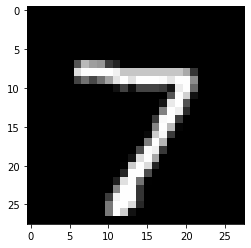

Prediction: 7 - Actual: 7


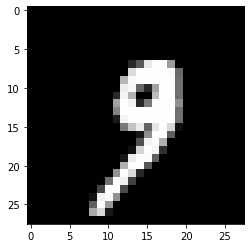

Prediction: 7 - Actual: 9


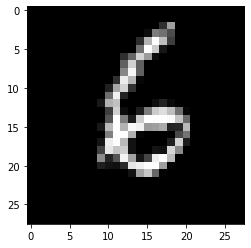

Prediction: 6 - Actual: 6


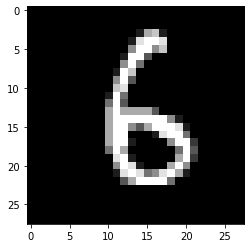

Prediction: 8 - Actual: 6


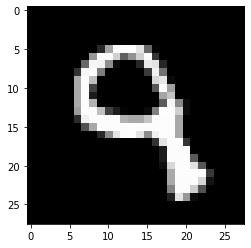

Prediction: 4 - Actual: 9


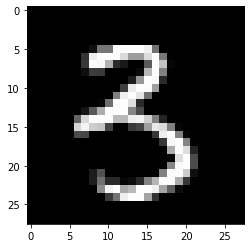

Prediction: 3 - Actual: 3


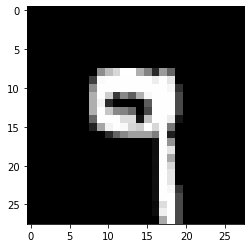

Prediction: 7 - Actual: 9


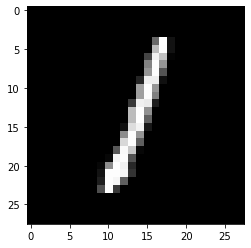

Prediction: 1 - Actual: 1


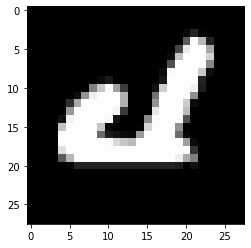

Prediction: 4 - Actual: 4


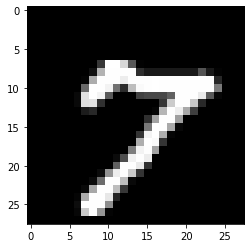

Prediction: 7 - Actual: 7


In [9]:
# Have the trained network predict on a number of images
mnist_loader = test_loader
predict_on_images(iterator = iter(mnist_loader), images_to_show = 10)

### End

Congratulations! You have now reached the end of Exercise 0. Make sure that you understand the steps above and then complete the Exercise 0 quiz in the Canvas Assignment.